# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [1]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests

# Import API key
from api_keys import geoapify_key

In [2]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("../output_data/cities.csv")

# Display sample data
city_data_df.head()


,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,as sulayyil,20.4607,45.5779,293.29,50,100,2.20,SA,1712007574
1,1,kourou,5.1552,-52.6478,302.18,85,89,3.00,GF,1712007862
2,2,adamstown,-25.0660,-130.1015,296.74,78,97,6.10,PN,1712007507
3,3,ilulissat,69.2167,-51.1000,271.16,80,75,0.51,GL,1712007507
4,4,port-aux-francais,-49.3500,70.2167,279.53,79,58,8.54,TF,1712007507


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

In [90]:
%%capture --no-display

# Configure the map plot
map_plot = city_data_df.hvplot.scatter(x='Lng', y='Lat', c='Humidity', cmap='Blues', hover_cols=['City'], size='Humidity', title='City Humidity')

# Display the map
map_plot

:Scatter   [Lng]   (Lat,Humidity,City)

### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [4]:

# Narrow down cities that fit criteria and drop any results with null values
ideal_conditions = (city_data_df["Max Temp"] > (20 + 273.15)) & (city_data_df["Max Temp"] < (29 + 273.15))


# Filter the DataFrame based on the ideal conditions and create a copy
ideal_cities_df = city_data_df[ideal_conditions].copy()

# Drop any rows with null values
ideal_cities_df.dropna(inplace=True)

# Display sample data
ideal_cities_df.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,as sulayyil,20.4607,45.5779,293.29,50,100,2.20,SA,1712007574
2,2,adamstown,-25.0660,-130.1015,296.74,78,97,6.10,PN,1712007507
6,6,bom jardim,-7.7958,-35.5872,298.08,87,76,2.76,BR,1712007575
9,9,georgetown,5.4112,100.3354,301.45,86,20,0.51,MY,1712007375
11,11,pemba,-12.9740,40.5178,300.54,88,75,3.60,MZ,1712007864


### Step 3: Create a new DataFrame called `hotel_df`.

In [5]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
hotel_df = ideal_cities_df[["City", "Country", "Lat", "Lng", "Humidity"]].copy()

# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df["Hotel Name"] = ""

# Display sample data
hotel_df.head()

,City,Country,Lat,Lng,Humidity,Hotel Name
0,as sulayyil,SA,20.4607,45.5779,50,
2,adamstown,PN,-25.0660,-130.1015,78,
6,bom jardim,BR,-7.7958,-35.5872,87,
9,georgetown,MY,5.4112,100.3354,86,
11,pemba,MZ,-12.9740,40.5178,88,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [91]:

# Set parameters to search for a hotel
radius = 10000
params = {
    "categories": "accommodation.hotel",  # Specify the type of place to search for (e.g., lodging/hotel)
    "apiKey": geoapify_key  
}

# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    # get latitude, longitude from the DataFrame
    lat, lng = row["Lat"], row["Lng"]
    
    # Add filter parameter with the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{lng},{lat},{radius}"
    params["bias"] = f"proximity:{lng},{lat}"
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"

    # Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    
       # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data
hotel_df

Starting hotel search
as sulayyil - nearest hotel: No hotel found
adamstown - nearest hotel: No hotel found
bom jardim - nearest hotel: Hotel Breno
georgetown - nearest hotel: Page 63 hostel
pemba - nearest hotel: Hotel Rafael
port mathurin - nearest hotel: Escale Vacances
netanya - nearest hotel: King Koresh
newman - nearest hotel: No hotel found
salalah - nearest hotel: Muscat International Hotel
saint-philippe - nearest hotel: Le Baril
pimentel - nearest hotel: Hospedaje Calle del Sol
arraial do cabo - nearest hotel: No hotel found
santiago de cao - nearest hotel: Hostal El Encanto
utrik - nearest hotel: No hotel found
hawaiian paradise park - nearest hotel: No hotel found
bogo - nearest hotel: R&F Function
tual - nearest hotel: Suita
uturoa - nearest hotel: Hawaiki Nui hotel
i-n-salah - nearest hotel: باجودة
fayetteville - nearest hotel: Regency Inn
west island - nearest hotel: Cocos Village Bungalows
myeik - nearest hotel: Green Eyes Hotel
karratha - nearest hotel: Karratha Intern

KeyboardInterrupt: 

### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

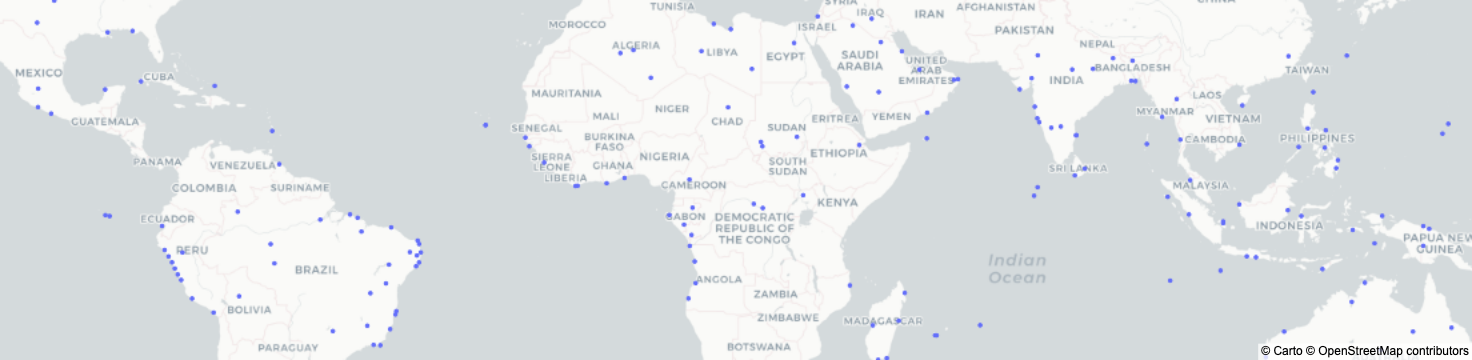

In [89]:
%%capture --no-display

import plotly.express as px

# Configure the map plot
fig = px.scatter_mapbox(hotel_df, 
                        lat="Lat", 
                        lon="Lng", 
                        hover_name="City", 
                        hover_data={"Hotel Name": True, "Country": True},  # Include additional hover data
                        zoom=2)

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Display the map
fig.show()